In [1]:
# Example showing the procedure of storm tracking and building storm catalog
# @author: Yuan Liu
# 2022/01/12

#### Basic package dependencies: Xarray, Numpy, Pandas

In [2]:
# import necesary packages
import xarray as xr
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### 0. Data preprocessing

We have to preprocess the ERA5 data, including: 

1) Compute the time derivative term $\frac{dw}{dt}$ by central differecing the total column water vapor term

2) Convert the units of precipitation $P$, moisture flux divergence $\nabla\cdot Q$, and evaporation $E$ from mm/s to mm/h, and shift the variables -1 hour to be consistent with the time derivative term $\frac{dw}{dt}$.

#### This step is skipped because the example data are already processed and stored in folder "/era5_data."

In [3]:
# import the preprocessing code
import era5_preprocessing

In [4]:
# # NOT RUN:
# # note that the file folder and file name should be customized based on downloaded ERA5 data, which are not provided in example
# raw_data_folder = r"E:\Atmosphere\Processed_data\ERA5\ERA5_single_level\1H\2019"
# # run the central difference on total column water vapor
# file_location = raw_data_folder + "\\" + "ERA5_hourly_total_column_water_vapour_2019_2019_1_2.nc"
# save_location = "era5_data\ERA5_hourly_dwdt_processed_2019_2019_1_2.nc"
# era5_preprocessing.time_difference(file_location, save_location)
# 
# # change the unit of evaporation, divergence, and precipitation
# variable_list = ['mean_evaporation_rate', "mean_total_precipitation_rate", "mean_vertically_integrated_moisture_divergence"]
# short_name_list = ['mer', 'mtpr', 'mvimd']
# for i in range(len(variable_list)):
#     file_location = raw_data_folder + "\\" + "ERA5_hourly_" + variable_list[i] + "_2019_2019_1_2.nc"
#     save_location = "era5_data\ERA5_hourly_" + short_name_list[i] + "_processed_2019_2019_1_2.nc"
#     era5_preprocessing.mean_rate_data_preprocessing(file_location, save_location)

### 1. Storm tracking and visualization

**Additional packages required: Scipy, Skimage, Tqdm**

We run the storm identification and tracking codes. The identificaiton and tracking results will be saved as .npy files, and the tracking results will be visualized and saved as .png in folder "/images."

1) Identification
    
The identification method integrates the double-threshold identification from the [TITAN algorithm](https://github.com/NCAR/lrose-titan) and almost-connected component labeling from the [STEP algorithm](https://github.com/RDCEP/STEP). First, the precipitation field is filtered with a high threshold of 0.5 mm/hour to retain storm regions with high precipitation. Second, the almost-connected-component labeling algorithm is implemented to cluster and label close precipitation regions as a single storm. In short, the algorithm uses a circular morphing structure with radius $Rm$ to erode and dilate the storm regions, where large storm areas are retained and clustered with nearby small precipitation regions. More details of the algorithm can be found in [Chang et al. (2016)](https://journals.ametsoc.org/view/journals/clim/29/23/jcli-d-15-0844.1.xml?tab_body=fulltext-display). Lastly, the identified storms are grown to a low threshold boundary of 0.03 mm/hour.


2) Tracking

The second step is to track storms across consecutive time steps, where the overlapping ratio method and a distance constraint are adopted. For storm $i$ in current time step $t_1$ and storm $j$ in previous time step $t_0$, the overlapping ratio $R$ is computed by the sum of the proportions of the overlapping area to the two storm areas:

<center>$R=\frac{A}{A_j}+\frac{A}{A_j}$</center>

where $A$ is the overlapping area between storm $i$ and storm $j$, $A_i$ is the area of storm $i$, $A_j$ is the area of storm $j$, and the areas are all measured by pixels. One threshold is empirically chosen so that the two potentially tracked storms should have an $R$ higher than 0.3. Also, the centroid distance between the two storms is constrained to be less than 15 pixels. The two storms with the highest overlapping ratio R while satisfying the threshold and constraint are tracked as one consecutive storm; otherwise, the current storm is labeled a new storm.

In [15]:
# import the storm identification, tracking, and visualizing codes
import identification
import tracking
import storm_visualization

In [16]:
# load the processed precipitation xarray
prcp_xarray = xr.open_dataset("era5_data\ERA5_hourly_mtpr_processed_2019_2019_1_2.nc")
# extract precipitation data
prcp_array = prcp_xarray['mtpr'].data
# extract the coordinates
lat_data = prcp_xarray['latitude'].data
lon_data = prcp_xarray['longitude'].data
time_stamp = prcp_xarray['time'].data.astype("datetime64[h]").astype("str")

# run storm identification
identify_array = identification.identification(prcp_array, high_threshold=0.5, low_threshold=0.03,
                                               morph_radius=4)
# save identified results
np.save(r"storm_tracking_results\identify_array.npy", identify_array)

# identify_array = np.load("identify_array.npy")
# run tracking using identified results
track_array = tracking.track(grown_array=identify_array, prcp_array=prcp_array, ratio_threshold=0.3,
                             max_distance=15, dry_spell_time=0)
# save tracking results
np.save(r"storm_tracking_results\tracking_array.npy", track_array)


Start the first loop in identification.



100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 2049.87it/s]



Start the second loop in identification.



100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:03<00:00, 32.36it/s]



Start the third loop in identification.



100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:02<00:00, 37.45it/s]



Start the forth loop in identification.



100%|███████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 19678.50it/s]



Start the fifth loop in identification.



100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 139.01it/s]



Start the sixth loop in identification.



100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 9222.96it/s]



Start the seventh loop in identification.



100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 719.98it/s]


In [17]:
# visualize tracking results
# create image save location
parent_loc = "images"
# make_folder(img_save_location)
# generated images
images = storm_visualization.sequence_storm_label_plot(track_array, timestamp=time_stamp, lon_data=lon_data, lat_data=lat_data,
                          save_location=parent_loc, title="Storm_tracking")

Generating figures: Storm_tracking


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:37<00:00,  2.64it/s]


The following code uses Basemap to visaulize the storm tracking results.

**Additonal packages required: Matplotlib, [Basemap Matplotlib Toolkit](https://matplotlib.org/basemap/users/installing.html)**

In [18]:
from matplotlib.colors import BoundaryNorm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
def sequence_strom_plot_basemap(labeled_storms, timestamp, lon_data, lat_data, save_location, cmap,
                              title="Precipitation intensity"):
    """
    function: 生成identified storms
    :param labeled_storms: 识别出的storm sequence [times, rows, cols]
    :param timestamp: nc数据的时间轴
    :param lon_data: longitude data vector
    :param lat_data: latitude data vector
    :param save_location： 图片保存路径
    :param title: 图片标题
    """
    # storm visualization
    colors = plt.get_cmap(cmap)
    print("Generating figures: " + title)
    # get the largest index of storm labels
    max_label = np.max(labeled_storms)
    for time_index in range(labeled_storms.shape[0]):
        fig, ax = plt.subplots(num=time_index, figsize=(5, 5))
        plt.title("Storm tracking results\n" + timestamp[time_index])
        # create a Basemap
        m = Basemap(llcrnrlon = -122, llcrnrlat = 14, urcrnrlon = -45, urcrnrlat = 48, projection='lcc', 
        resolution='c', lat_0=40, lon_0=-106.)
        # give continents a color and transparency
        res = m.fillcontinents(color='#bdbdbd', alpha=0.3)
        
        # convert to new coordinates
        # link our lat and long tutorial_data to the map
        lon_2, lat_2 = np.meshgrid(lon_data,lat_data)
        row_num = lat_data.shape[0]
        col_num = lon_data.shape[0]
        x, y = m(lon_2, lat_2)
        m.pcolormesh(x, y, np.ma.masked_where(labeled_storms[time_index] == 0, labeled_storms[time_index]),
                    cmap=colors, shading='auto')
        plt.clim((0, np.max(labeled_storms)))
        
    return

def index_remap(raw_labeled_storms):
    # get raw index
    raw_index = np.unique(raw_labeled_storms)
    # generate new index
    new_index = np.arange(0, raw_index.shape[0])
    for i in range(raw_index.shape[0]):
        if i == 0:
            continue
        else:
            # update new index
            # print(raw_index[i])
            raw_labeled_storms = np.where(raw_labeled_storms==raw_index[i], new_index[i], raw_labeled_storms)
    
    return raw_labeled_storms

Generating figures: ERA5


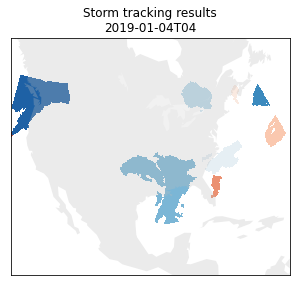

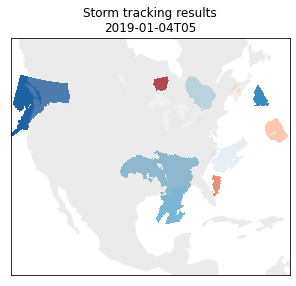

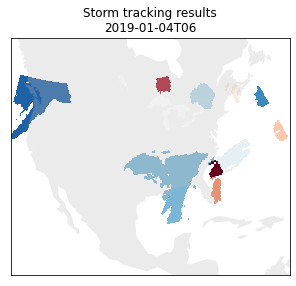

In [22]:
# visualize one of the tracking results
timestamp = prcp_xarray['time'].data.astype("datetime64[h]").astype("str")
start_time = '2019-01-04T04'
time_index = np.argwhere(timestamp == start_time)[0][0]
duration = 3
time_seq = timestamp[time_index: time_index + duration]
raw_labeled_storms = track_array[time_index: time_index + duration]
lat_data = prcp_xarray['latitude'].data
lon_data = prcp_xarray['longitude'].data
labeled_storms = index_remap(raw_labeled_storms)
# extract the time step and lat and lon data from ERA5
save_location = r"D:\Atmopshere_notes\Papers\Figures\Figure_track_results\No_rec"
sequence_strom_plot_basemap(labeled_storms = labeled_storms, timestamp = time_seq, lon_data = lon_data, 
                           lat_data = lat_data, save_location = save_location,cmap = 'RdBu_r', 
                              title="ERA5")

### 2. Create hourly storm catalog over CONUS

**Additional Packages required: [mpu](https://github.com/MartinThoma/mpu), [geographiclib](https://geographiclib.sourceforge.io/html/python/)**

Based on the tracking result, we create hourly storm catalogs for storms over the Contiguous United States (CONUS). Two kinds of storm catalogs are created in our example:

1) "full_storm_catalog_2019.pkl": The dataframe contains all the storm records.

2) "land_storm_catalog_2019.pkl": The dataframe only contains the storm records over the land of the CONUS.

The storm catalog contains following attributes:

1) 'ID': 9-digit storm ID

2) 'Projected_area(sqkm)': Area of the full storm object (land area + sea area) 

3) 'Timestamp': Current time step of the storm

4) 'Avg_intensity(mm/h)': Average intensity of the storm

5) 'Max_intensity(mm/h)': Max intensity of the storm

6) 'Duration(hour)': Storm duration

7) 'DurationDays(day)': Storm duration in day

8) 'Central_lon(degree)': Latitude of the storm centroid

9) 'Central_lat(degree)': Longitude of the storm centroid

10) 'Season': Storm season

11) 'Season_id': Integer representing the season, where 1 for spring, 2 for summer, 3 for fall, and 4 for winter

12) 'Month': Storm month

13) 'Distance(km)': Move distance of storm centroid.

14) 'Bearing(degree)': Move direction of the storm centroid.

15) 'Land_area(sqkm)': Storm area over the land.

16) 'Land_area_avg_mtpr(mm/h)': Average precipitation at the land part of the storm. 

17) 'Land_area_avg_mer(mm/h)': Average evaporation at the land part of the storm.

18) 'Land_area_avg_dwdt(mm/h)': Average time derivative of precipitable water at the land part of the storm

19) 'Land_area_avg_mvimd(mm/h)': Average moisture flux divergence at the land part of the storm

20) 'Land_area_avg_residual(mm/h):Average moisture residual at the land part of the storm


In [23]:
# import code to compute storm catalogs
import initial_storm_catalog

In [26]:
# define save location
save_loc = "hourly_catalog"
# create a new folder
initial_storm_catalog.make_folder(save_loc)
# load tracking data
tracked_storm_loc = "storm_tracking_results/tracking_array.npy"
track_storms = np.load(tracked_storm_loc, allow_pickle=True)
# load precipitation data
mtpr_xarray = xr.open_dataset("era5_data" + "\\" + "ERA5_hourly_mtpr_processed_2019_2019_1_2.nc")
# load evaporation data
mer_xarray = xr.open_dataset("era5_data" + "\\" + "ERA5_hourly_mer_processed_2019_2019_1_2.nc")
# load divergence data
mvimd_xarray = xr.open_dataset("era5_data" + "\\" + "ERA5_hourly_mvimd_processed_2019_2019_1_2.nc")
# load time derivative data
dwdt_xarray = xr.open_dataset("era5_data" + "\\" + "ERA5_hourly_dwdt_processed_2019_2019_1_2.nc")

# set parameters
year = 2019
low_threshold = 0.03
conus_boundary = np.load("boundary_files/conus_boundary.npy")
initial_storm_catalog.build_storm_catalog(year, low_threshold, track_storms, mtpr_xarray, mer_xarray,
                    mvimd_xarray, dwdt_xarray, conus_boundary, save_loc)

Total storm number: 172
Storm catalog in 2019 finished, time spent: 16.586820125579834 s


In [27]:
# show the storm catalog
land_storm_catalog = pd.read_pickle(r"hourly_catalog/land_storm_catalog_2019.pkl")
land_storm_catalog.head(5)

,ID,Projected_area(sqkm),Timestamp,Avg_intensity(mm/h),Max_intensity(mm/h),Duration(hour),DurationDays(day),Central_lon(degree),Central_lat(degree),Season,Season_id,Month,Distance(km),Bearing(degree),Land_area(sqkm),Land_area_avg_mtpr(mm/h),Land_area_avg_mer(mm/h),Land_area_avg_dwdt(mm/h),Land_area_avg_mvimd(mm/h),Land_area_avg_residual(mm/h)
0,201900001,2439862.25,2019-01-01 00:00:00,0.957313,7.654540,19,1,-80.904205,41.303905,win,4,1,0.000000,0.000000,1565628.000,1.096425,-0.028055,-0.341934,-0.712639,0.013797
1,201900001,2442457.00,2019-01-01 01:00:00,0.930414,5.873730,19,1,-79.774429,41.591961,win,4,1,99.461073,70.906506,1424978.500,1.123739,-0.026508,-0.313690,-0.642035,0.141506
2,201900001,2368602.00,2019-01-01 02:00:00,0.920706,5.062569,19,1,-78.582130,42.176979,win,4,1,118.209478,56.313914,1246657.125,1.089624,-0.024390,-0.556138,-0.256444,0.252653
3,201900001,2024650.25,2019-01-01 03:00:00,0.948868,6.365911,19,1,-76.450928,43.348606,win,4,1,217.341532,52.553703,800194.625,1.185432,-0.004603,-0.381118,-0.652812,0.146899
4,201900001,1901759.50,2019-01-01 04:00:00,1.007689,7.870537,19,1,-75.110886,43.517738,win,4,1,109.825515,79.714150,666070.500,1.236334,-0.004625,-0.558435,-0.635941,0.037333


### 3. Create sub-basin storm catalog

Next, we classify the storm record based on its presense in each sub-basin and adjust the duration accordingly. The storm is 
considered to be inside one sub-basin if its overlapping area to the sub-basin is larger than 2,500 sqkm or overlapping precipitation is higher than 0.1 mm/hour. New sub-basin storm catalogs are created with naming convention as "arkansas_land_storm_catalog_2019.pkl".

New variables are added into the catalog:

1) 'land_cen_lat': centroid latitude of the land part of the storm

2) 'land_cen_lon': centroid longitude of the land part of the storm

3) 'arkansas_area_avg_mtpr(mm/h)': storm average precipitation over the Arkansas-Red sub-basin

4) 'arkansas_area(sqkm)': storm area over the Arkansas-Red sub-basin

5) 'arkansas_storm': binary indicator, 1 for storm is classfied into the sub-basin, 0 otherwise

6) 'sbasin_duration(hour)': storm duration over the sub-basin

7) 'sbasin_durationday(day)': storm duration over the sub-basin in day

Note that variables 3, 4, and 5 are also computed for the other sub-basins with sub-basin prefixes changed.

In [28]:
import sbasin_classify

In [29]:
area_threshold = 2500
prcp_threshold = 0.1
sbasin_classify.storm_basin_classify(year, area_threshold, prcp_threshold, save_loc=save_loc)

Classify sub-basin storm in 2019
Finish classify sub-basin storm in 2019 in time 4.955068349838257s


In [30]:
# show the storm catalog of one sub-basin
land_storm_catalog = pd.read_pickle(r"hourly_catalog/arkansas_land_storm_catalog_2019.pkl")
land_storm_catalog.head(5)

,ID,Projected_area(sqkm),Timestamp,Avg_intensity(mm/h),Max_intensity(mm/h),Duration(hour),DurationDays(day),Central_lon(degree),Central_lat(degree),Season,...,missouri_area(sqkm),missouri_storm,up_miss_area_avg_mtpr(mm/h),up_miss_area(sqkm),up_miss_storm,ohio_area_avg_mtpr(mm/h),ohio_area(sqkm),ohio_storm,sbasin_duration(hour),sbasin_durationday(day)
0,201900003,618939.7500,2019-01-01 00:00:00,0.367964,3.247989,23,1,-108.957642,35.457657,win,...,50041.328125,1,0.0,0.0,0,0.0,0.0,0,21,1
1,201900003,613673.3750,2019-01-01 01:00:00,0.410921,3.515144,23,1,-108.995224,35.208199,win,...,47753.972656,1,0.0,0.0,0,0.0,0.0,0,21,1
2,201900003,608712.0625,2019-01-01 02:00:00,0.454013,3.362340,23,1,-108.962601,35.039288,win,...,45372.703125,1,0.0,0.0,0,0.0,0.0,0,21,1
3,201900003,584134.1250,2019-01-01 03:00:00,0.510535,3.348966,23,1,-108.953964,34.875950,win,...,38340.031250,1,0.0,0.0,0,0.0,0.0,0,21,1
4,201900003,577577.0625,2019-01-01 04:00:00,0.481037,2.909615,23,1,-108.753212,34.916157,win,...,36640.000000,1,0.0,0.0,0,0.0,0.0,0,21,1


### 4. Extract sub-basin storm events with a specific duration and area
**Additional packages required: Skimage**

We will extract storm events with a specific duration $D$ and area $A$ from the sub-basin storm catalog. First, storms in the sub-basin catalog that have duration longer than $D$ are selected. For each storm record, the period with the duration of $D$ that has the highest precipitation is exacted. Second, in the extract period, an area selection algorithm is applied to find the contiguous region with the area of $A$ that has the highest precipitation in the sub-basin. 
The area selection algorithm is based on binary and greedy search. First, the spatial composite of the precipitation fields is built by adding the storm precipitations during the extracted period $D$. Second, the binary search is implemented to find a precipitation contour closest to the target area $A$ over the spatial composite. Finally, the algorithm recursively expands the contour area with the neighboring pixel that has the highest precipitation, until the difference between the selected area and the target area $A$ is less than one pixel.

In [31]:
import area_duration_selector

In [32]:
area_of_interest = 25000
duration_of_interest = 2
sbasin_name = 'arkansas'
area_duration_selector.build_subset_sbasin_storm_catalog(year, area_of_interest, duration_of_interest, sbasin_name)

Create subset for sbasin arkansas with area 25000 sqkm and duration 2 hour in year2019.
Finish subset for sbasin arkansas with area 25000 sqkm and duration 2 hour in year2019.
Time spent 0.4848029613494873 s


Visualize the sub-basin storm catalog:

In [33]:
# visualize the 
sbasin_catalog = pd.read_pickle(r"subbasin_catalog/arkansas/2019/area_25000_duration_2/arkansas_subset_storm_catalog_2019.pkl")
sbasin_catalog.head(5)

,ID,start_time,end_time,subset_cen_lon,subset_cen_lat,subset_duration(hour),subset_area(sqkm),subset_ture_area(sqkm),raw_duration(hour),raw_timestamp(hour),...,avg_spd(km/hour),avg_bearing(degree),raw_avg_land_area(sqkm),arkansas_storm,selected_mtpr(mm/hour),land_mtpr,land_mer,land_mvimd,land_dwdt,land_residual
0,201900003,2019-01-01 01:00:00,2019-01-01 02:00:00,-104.699318,35.937366,2,25000,25553.378906,21,2019-01-01 00:00:00,...,23.481085,-0.988611,5.933853e+05,1,0.918479,0.918479,-0.007897,-0.794014,-0.179988,-0.063420
1,201900028,2019-01-02 08:00:00,2019-01-02 09:00:00,-94.732895,32.689430,2,25000,9711.091797,3,2019-01-02 07:00:00,...,206.403452,-35.814827,2.554474e+05,1,0.088097,0.090266,-0.011143,-1.530632,1.663543,0.212034
2,201900050,2019-01-02 04:00:00,2019-01-02 05:00:00,-93.613655,32.402912,2,25000,14957.019531,3,2019-01-02 03:00:00,...,43.616380,0.576589,4.434139e+04,1,0.226020,0.227300,-0.028160,-1.895705,1.958018,0.261452
3,201900058,2019-01-02 18:00:00,2019-01-02 19:00:00,-93.877670,32.233486,2,25000,24705.359375,26,2019-01-02 09:00:00,...,279.166337,-10.515507,1.078481e+06,1,4.113183,4.113183,-0.067357,-4.195724,0.126517,-0.023381
4,201900082,2019-01-02 20:00:00,2019-01-02 21:00:00,-98.355286,34.068142,2,25000,25517.082031,2,2019-01-02 20:00:00,...,11.972064,17.121496,4.094120e+04,1,0.237687,0.244161,-0.032334,-1.004689,0.445283,-0.347580


### 5. Build annual maximum storm catalog

By performing the storm tracking and area-duration selector on ERA5 data from 1951 to 2020, we can create a 70 years of storm event catalog over a sub-basin. The annual maximum storm catalog is built by extracting the storm events with the largest precipitation each year. We skip the computation of 70-year data in the example and directly show the final annual maximum storm catalog for events with 25,000 sqkm and 2 hours at the Arkansas-Red sub-basin.

In [34]:
import annual_maximum_catalog

In [35]:
# NOT RUN:
# set up the parameters
# year_list = np.arange(1951, 2021)
# area_list = [25000]
# duration_list = [2]
# sbasin_list = ['arkansas']

# get annual maximum of each case
# for sbasin_name  in sbasin_list:
#     for area_of_interest in area_list:
#         for duration_of_interest in duration_list:
#             annual_maximum_catalog.annual_maximum_selector(area_of_interest, duration_of_interest, sbasin_name)

In [36]:
annual_maximum_catalog = pd.read_pickle(r"annual_maximum_catalog\arkansas\area_25000_duration_2\annual_maximum_subset_storm_catalog.pkl")
annual_maximum_catalog.head(5)

,ID,start_time,end_time,subset_cen_lon,subset_cen_lat,subset_duration(hour),subset_area(sqkm),subset_ture_area(sqkm),raw_duration(hour),raw_timestamp(hour),...,avg_bearing(degree),raw_avg_land_area(sqkm),arkansas_storm,selected_mtpr(mm/hour),land_mtpr,land_mer,land_mvimd,land_dwdt,land_residual,year
0,195104370,1951-06-11 12:00:00,1951-06-11 13:00:00,-97.328232,35.229107,2,25000,25162.021484,48,1951-06-10 16:00:00,...,118.778161,6.253063e+05,1,11.105352,11.105352,-0.040518,-13.345479,0.896135,-1.384510,1951
1,195210510,1952-11-25 11:00:00,1952-11-25 12:00:00,-93.752403,35.439995,2,25000,25082.566406,78,1952-11-23 03:00:00,...,18.556807,2.112212e+06,1,10.041810,10.041810,0.011937,-9.175941,0.146171,1.023977,1952
2,195306265,1953-07-20 11:00:00,1953-07-20 12:00:00,-94.811638,35.559273,2,25000,25057.042969,98,1953-07-18 06:00:00,...,-120.934060,9.431787e+05,1,9.521101,9.521101,-0.052527,-11.003201,0.598229,-0.936399,1953
3,195402801,1954-04-30 18:00:00,1954-04-30 19:00:00,-95.629295,35.563248,2,25000,25066.132812,51,1954-04-29 15:00:00,...,41.260900,1.374466e+06,1,12.785565,12.785565,-0.139519,-10.351785,-3.306462,-1.012200,1954
4,195504722,1955-06-19 07:00:00,1955-06-19 08:00:00,-100.059647,35.844257,2,25000,25581.455078,25,1955-06-18 20:00:00,...,134.441506,1.122433e+05,1,7.908501,7.908501,-0.033169,-8.929108,-0.078780,-1.132556,1955
